In [1]:
from pathlib import Path
import sys


import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
import logging
import tifffile
from colokroll.core.format_converter import FormatConverter
from colokroll.data_processing import ImageLoader
from colokroll.imaging_preprocessing.background_subtraction.background_subtractor import BackgroundSubtractor
from colokroll.analysis.cell_segmentation import CellSegmenter
from colokroll.analysis.colocalization import compute_colocalization, export_colocalization_json


# Setup logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

/users/PAS2598/duarte63/GitHub/perinuclear_analysis/colokroll/__init__.py:41: UserWarning: MIPPreprocessor not available yet
  warnings.warn("MIPPreprocessor not available yet")
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/colokroll/__init__.py:61: UserWarning: Phase 4 dependencies not installed: No module named 'colokroll.ring_analysis'
Install with: pip install .[phase4]
  warnings.warn(
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/colokroll/__init__.py:74: UserWarning: Phase 5 dependencies not installed: No module named 'colokroll.signal_quantification'
Install with: pip install .[phase5]
  warnings.warn(


In [2]:
image_path = Path("/fs/scratch/PAS2598/duarte63/ALIX_confocal_data/Madi/2025-09-18_U2OS_NTC_30 min_60X_DAPI_ALIX(488)_Phallodin(568)_LAMP1(647)_01.ome.tiff")
image_loader = ImageLoader()

loaded_data = image_loader.load_image(image_path)
image_loader.get_pixel_size()
loaded_data.dtype

# Rename Channels -> Index (If you don't know what's the order; after image_loader.load_image you can image_loader.get_channel_names()
# and it will show you the actual names in order

new_channel_names = ['DAPI', 'ALIX', 'Phalloidin', 'LAMP1']
channel_names = image_loader.rename_channels(new_channel_names)

channel_names = image_loader.get_channel_names()

INFO: Loaded metadata from converted TIFF: pixel_size=0.414320379601492μm
INFO: Successfully loaded TIFF image with shape: (6, 512, 512, 4)
INFO: Renamed channels to: ['DAPI', 'ALIX', 'Phalloidin', 'LAMP1']


In [7]:
channel_names

['DAPI', 'ALIX', 'Phalloidin', 'LAMP1']

In [3]:
bg_subtractor = BackgroundSubtractor()

results = {}

for i, ch in enumerate(channel_names):
    ch_data = loaded_data[:, :, :, i]
    t0 = time.perf_counter()
    corrected, meta = bg_subtractor.subtract_background(
        image=ch_data,
        channel_name=ch,
        # method omitted -> auto search + full run
    )
    cp.cuda.Stream.null.synchronize()
    dt = time.perf_counter() - t0

    results[ch] = (corrected, meta)

INFO: Initializing CUDA-accelerated background subtractor (CUDA required)
INFO: GPU Memory: 39.0GB free / 39.4GB total
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=100)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=110)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=120)
INFO: Processing 6 z-slices with CUDA rolling ball approximation (radius=100)
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=10
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=12
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=14
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=16
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=10
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=50)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=55)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radi

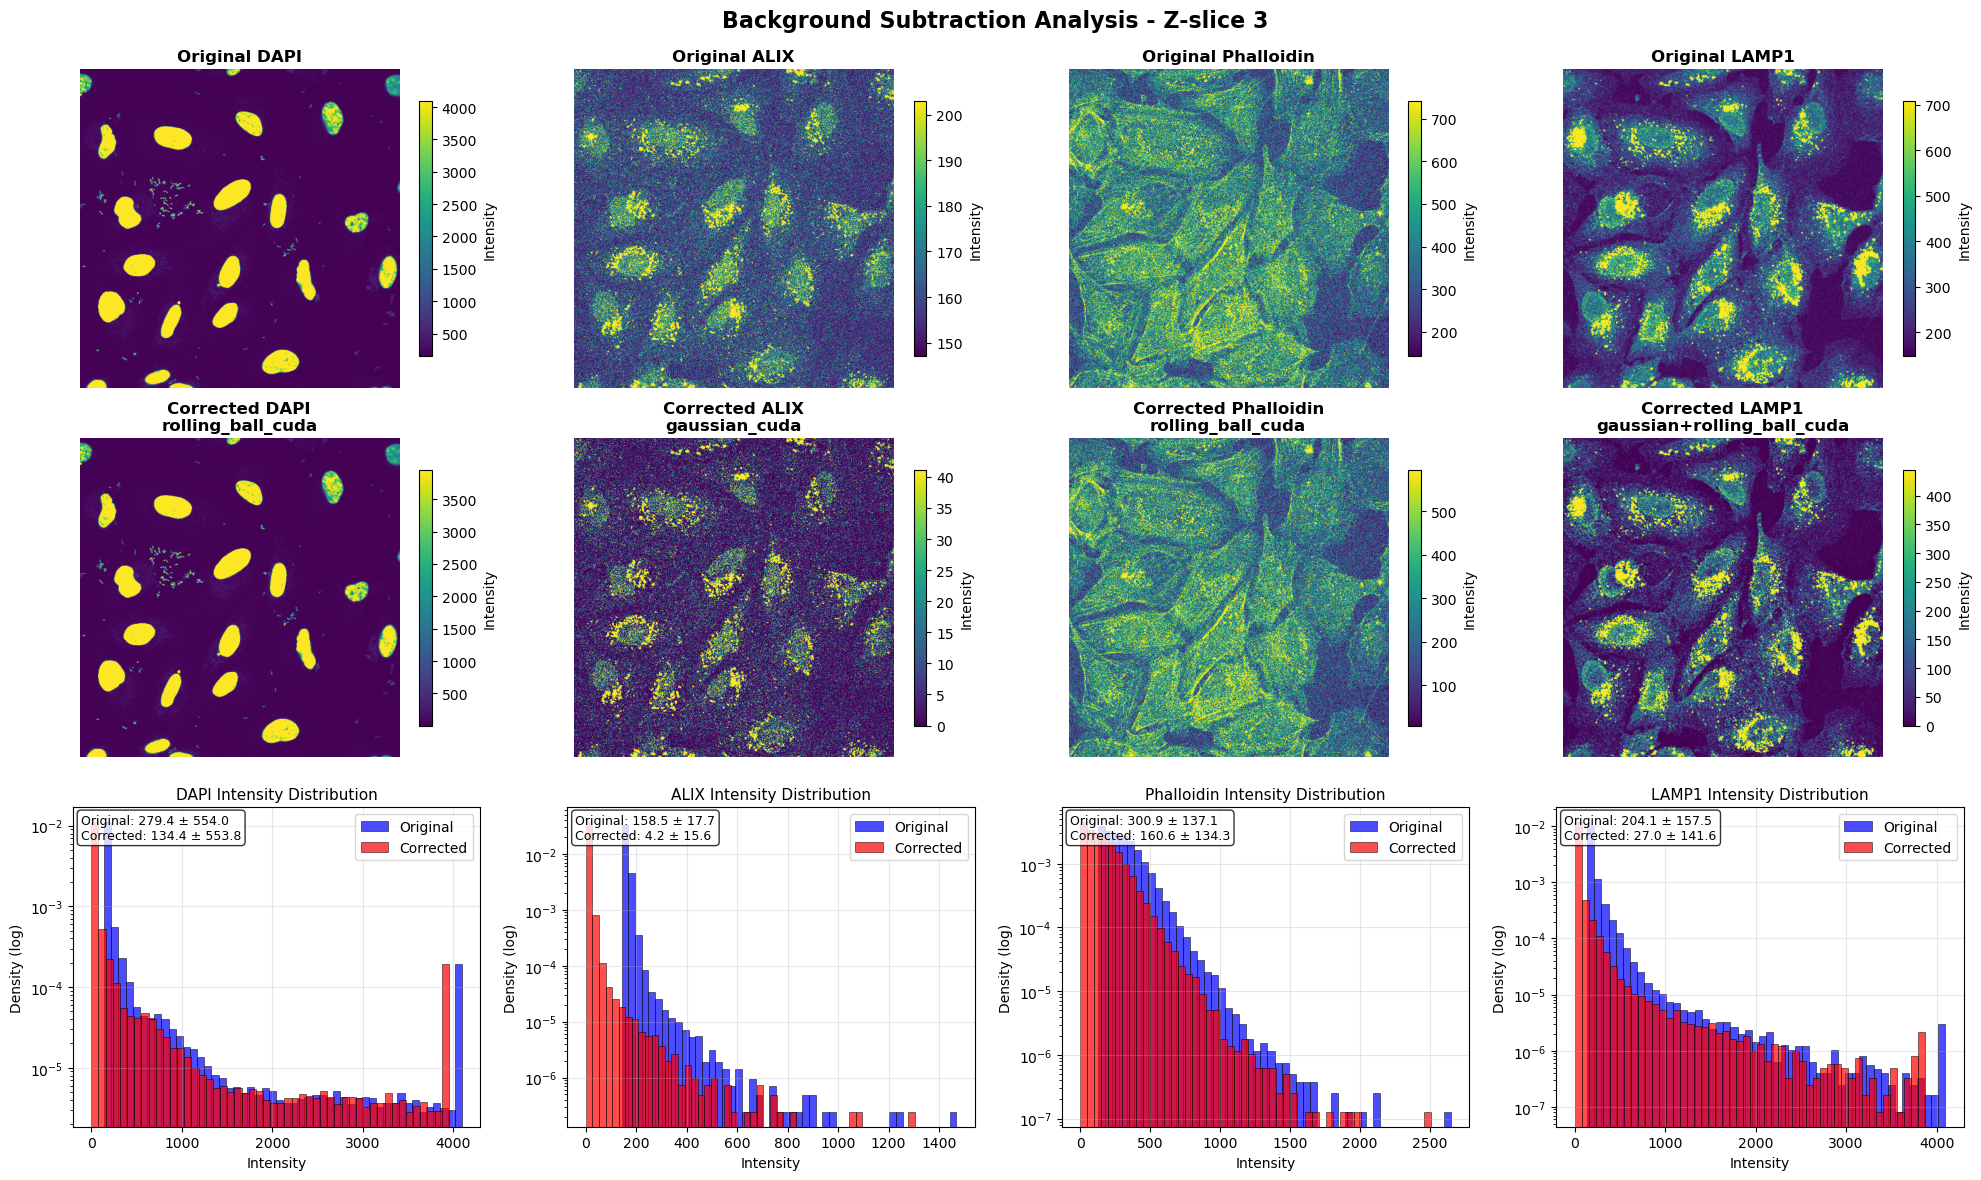

In [4]:
middle_slice_idx = loaded_data.shape[0]//2


fig = bg_subtractor.plot_background_subtraction_comparison(
    original_data=loaded_data,
    corrected_results=results,
    channel_names=channel_names,
    z_slice=middle_slice_idx,
    figsize=(5*len(channel_names), 12)
)
plt.show()

Loaded as API: https://mouseland-cellpose.hf.space ✔


INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/config "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/info?serialize=False "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/heartbeat/c7012952-7945-4b72-a202-f8cf58fd3fc9 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/upload "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/queue/join "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/queue/data?session_hash=c7012952-7945-4b72-a202-f8cf58fd3fc9 "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/file=/tmp/gradio/a4d122d7a485d4a49aff2b350e1c3902d3a9ed05266ac918c0586ecd06690a22/composite.png "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/file=/tmp/gradio/a4d122d7a485d4a49aff2b350e1c3902d3a9ed05266ac918

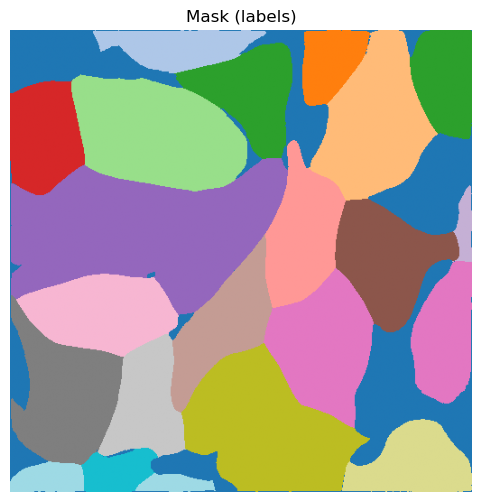

In [5]:
from gradio_client import Client, handle_file
from colokroll.analysis.segmentation_config import get_hf_token
import imageio.v3 as iio
import os

# 0) Build/validate composite (if not already done)
def norm01(a):
    a = a.astype(np.float32); mn, mx = a.min(), a.max()
    return np.zeros_like(a) if mx <= mn else (a - mn) / (mx - mn)
ph_idx = channel_names.index("Phalloidin"); da_idx = channel_names.index("DAPI")
ph_mip = loaded_data[..., ph_idx].max(axis=0).astype(np.float32)
da_mip = loaded_data[..., da_idx].max(axis=0).astype(np.float32)
composite = 0.8*norm01(ph_mip) + 0.2*norm01(da_mip)
composite = np.clip(np.nan_to_num(composite, nan=0.0, posinf=1.0, neginf=0.0), 0, 1).astype(np.float32)

# 1) temp PNG
tmp_png = "/tmp/composite.png"
iio.imwrite(tmp_png, (composite*255).astype(np.uint8))

# 2) Authenticated client
token = get_hf_token()
client = Client("mouseland/cellpose", hf_token=token)

# 3) Two-step flow with pause + retry
def run_seg(resize):
    _ = client.predict(filepath=handle_file(tmp_png), api_name="/update_button") 
    time.sleep(1.0)
    return client.predict(
        filepath=[handle_file(tmp_png)],
        resize=resize, max_iter=250, flow_threshold=0.4, cellprob_threshold=0.0,
        api_name="/cellpose_segment",
    )

result = None
for rs in (600, 400):
    try:
        result = run_seg(rs)
        break
    except Exception as e:
        print(f"retry with smaller resize due to: {e}")
        time.sleep(1.0)

if result is None:
    raise RuntimeError("Cellpose Space failed after retries")

# 4) outputs and save to folder
masks_tif = result[2]["value"] if isinstance(result[2], dict) else (result[2].path if hasattr(result[2],"path") else result[2])
outlines_png = result[3]["value"] if isinstance(result[3], dict) else (result[3].path if hasattr(result[3],"path") else result[3])

mask = iio.imread(str(masks_tif)).astype(np.int32)
save_dir = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose"); save_dir.mkdir(parents=True, exist_ok=True)
dst_mask = save_dir / f"{image_path.stem}_phall_dapi_masks.tif"
dst_outl = save_dir / f"{image_path.stem}_phall_dapi_outlines.png"
Path(dst_mask).write_bytes(Path(masks_tif).read_bytes())
Path(dst_outl).write_bytes(Path(outlines_png).read_bytes())

plt.figure(figsize=(6,6))
plt.title("Mask (labels)")
plt.imshow(mask, cmap="tab20")
plt.axis("off")
plt.show()

INFO: Loading TIF mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/2025-09-18_U2OS_NTC_30 min_60X_DAPI_ALIX(488)_Phallodin(568)_LAMP1(647)_01.ome_phall_dapi_masks.tif
INFO: Mask contains 26 unique values
INFO: Successfully loaded mask with shape: (512, 512)
INFO: Loaded labeled mask with integer dtype: uint16
INFO: Estimated min_area threshold: fraction=0.7, median_area=9002 -> thr=6301
INFO: Starting compute_colocalization(ch_a=ALIX, ch_b=LAMP1, normalization_scope=none, min_area=6301, max_border_fraction=0.1, border_margin_px=1, plot_mask=True)
INFO: Loading TIF mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/2025-09-18_U2OS_NTC_30 min_60X_DAPI_ALIX(488)_Phallodin(568)_LAMP1(647)_01.ome_phall_dapi_masks.tif
INFO: Mask contains 26 unique values
INFO: Successfully loaded mask with shape: (512, 512)
INFO: Loaded labeled mask with integer dtype: uint16
INFO: Image loaded: shape=(6, 512, 512, 4), channels=['DAPI', 'ALIX', 'Phalloidin', 'LAMP1'] | Mask loaded: shape=(512, 512), uniq

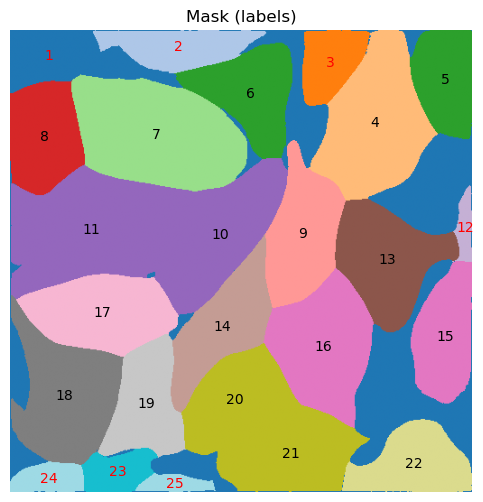

INFO: Displayed mask with label indices (kept=18, removed=7)
INFO: Normalization disabled (scope='none')
INFO: Computed metrics for 18 labels; total_image n_voxels=1239858.0
INFO: compute_colocalization finished.


In [6]:
import pandas as pd
from colokroll.analysis.colocalization import _load_mask, estimate_min_area_threshold

channels = channel_names 

mask_path = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose/2025-09-18_U2OS_NTC_30 min_60X_DAPI_ALIX(488)_Phallodin(568)_LAMP1(647)_01.ome_phall_dapi_masks.tif")

min_area = estimate_min_area_threshold(mask_path, fraction_of_median=0.70)

res = compute_colocalization(
    image=results,  # dict[str, (array, meta)] or dict[str, array]
    mask=mask_path,
    channel_a="ALIX",
    channel_b="LAMP1",
    thresholding='costes',
    max_border_fraction=0.10,
    min_area=int(min_area),
    border_margin_px=1,
    plot_mask=True,
)

res["results"]["total_image"]

# Per-cell dataframe (one row per kept label)
df_cells = pd.DataFrame(res["results"]["per_label"]).sort_values("label")
# Optional: save
# df_cells.to_csv("per_cell_metrics.csv", index=False)

# Total-image (single row)
df_total = pd.DataFrame([res["results"]["total_image"]])

In [7]:
df_cells

,pearson_r,manders_m1,manders_m2,overlap_r,jaccard,n_voxels,thresholds,type,label
0,0.570018,0.460410,0.658116,0.596552,0.283941,94644.0,"{'t_a': 2.7040343284606934, 't_b': 17.37909934...",cell4,4
1,0.406956,0.480022,0.567275,0.464100,0.282574,41430.0,"{'t_a': 1.6846003532409668, 't_b': 13.18952859...",cell5,5
2,0.681353,0.501826,0.675730,0.700528,0.283430,54012.0,"{'t_a': 2.7762222290039062, 't_b': 17.44430941...",cell6,6
3,0.367824,0.434679,0.623845,0.399735,0.281070,113052.0,"{'t_a': 6.3910441398620605, 't_b': 27.81406048...",cell7,7
4,0.468201,0.483766,0.675902,0.504050,0.294853,51018.0,"{'t_a': 3.3877816200256348, 't_b': 32.42749898...",cell8,8
5,0.521716,0.542592,0.767785,0.548548,0.298253,61608.0,"{'t_a': 1.8877763748168945, 't_b': 17.61678463...",cell9,9
6,0.655001,0.521229,0.687744,0.670099,0.294257,78654.0,"{'t_a': 5.316645622253418, 't_b': 34.315249134...",cell10,10
7,0.553114,0.415614,0.709661,0.569009,0.275202,119922.0,"{'t_a': 3.9999568462371826, 't_b': 25.11226233...",cell11,11
8,0.539541,0.501765,0.715923,0.573756,0.292955,69336.0,"{'t_a': 2.0444610118865967, 't_b': 17.66761325...",cell13,13
9,0.444528,0.551539,0.780792,0.472504,0.299282,57864.0,"{'t_a': 2.216696262359619, 't_b': 24.013632291...",cell14,14
